# Speed-up GT generation
[OCR4all](https://github.com/OCR4all) is a great (and easy-to-use) tool to do high-quality OCR of old books. In order to get good results (over 99% correctness is possible) GT must be generated. Within the OCR4all workflow, this is done with LAREX. LAREX allows for very detailed annotation, as of now, however, it doesn't provide any batch editing features.

The following script offers a very simplistic method to select and correct particularly interesting lines. The selection is done via REGEX. It can be useful to focus on certain patterns during GT creation. If you notice e.g. a very poor performance of your models when it comes to numbers, you can choose specifically lines containing numbers (`regex = r"\d+"`), if you notice that 'ſſ' is often transcribed as 'ſf', you can filter these lines with `regex = r"(fſ|ſf)"` and so on.

In [ ]:
# Import necessary modules
from glob import glob
from lxml import etree
from matplotlib import pyplot as plt
import re
from shapely.geometry import Polygon
import matplotlib.image as mpimg
import numpy as np
import shutil
import os
import pyperclip

In [3]:
# Provide the path to the OCR4all project directory (contains folders `input` and `processing`):
project_directory = "/home/alex/ocr4all/data/Barg_Syr_1585"

In [4]:
pagexml = glob(project_directory+"/processing/*.xml")
pagexml.sort()

In [17]:
regex = r"^[a-z]"

The script shows line snippets and the ocr transcription. The ocr transcription is also stored in the clipboard and can be pasted easily (ctrl+c). This is a pragmatic workaround as Python's `input()` function doesn't allow prefill. If you don't want to alter the ocr (and consequently generate no GT) hit enter. If you want to delete the line, type ` d ` (a space before and after the `d`).
If changes are made, the original PageXML is overwritten, but a backup is written to the `backup_processing` directory. It is, of course, wise to use (e.g.) git as well for tracking changes.

/home/alex/ocr4all/data/Barg_Syr_1585/processing/0013.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0013.xml	0013.png
(199.0, 276.0, 1066.0, 334.0)


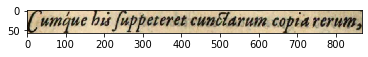

umq́ue his ſuppeteret cunctarum copia rerum,
Cumq́ue his ſuppeteret cunctarum copia rerum,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0013.xml	0013.png
(201.0, 508.0, 949.0, 566.0)


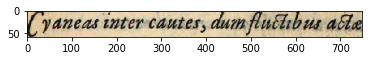

yaneas inter cautes, dum ſluctibus actæ
Cyaneas inter cautes, dum fluctibus actæ
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0013.xml	0013.png
(200.0, 799.0, 966.0, 856.0)


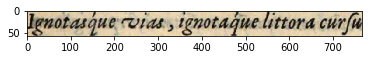

gnotasque vias, ignotaque littora curſu
Ignotasq́ue vias, ignotaq́ue littora curſu
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0013.xml	0013.png
(204.0, 972.0, 1151.0, 1030.0)


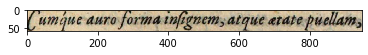

umq́ue auro forma inſignem, atque ætate puellam,
Cumq́ue auro forma inſignem, atque ætate puellam,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0014.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0015.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0015.xml	0015.png
(199.0, 907.0, 1034.0, 970.0)


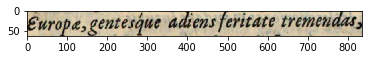

uropæ, gentesq́ue adiens feritate tremendas,
Europæ, gentesq́ue adiens feritate tremendas,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0015.xml	0015.png
(208.0, 1656.0, 1013.0, 1725.0)


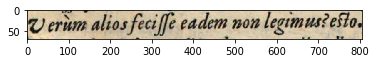

erùm alios feciſſe eadem non legimus?eſto.
Verùm alios feciſſe eadem non legimus? esto.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0016.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0016.xml	0016.png
(342.0, 717.0, 1083.0, 763.0)


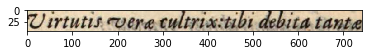

irtutis veræ cultrix: tibi debita tantæ
Virtutis veræ cultrix: tibi debita tantæ
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0017.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0018.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0019.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0019.xml	0019.png
(557.0, 1215.0, 1252.0, 1296.0)


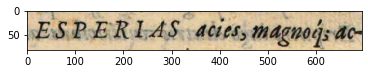

aP ES PERIAS acis, agnoq: a-
ESPERIAS acies, magnoq́: ac-
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0019.xml	0019.png
(557.0, 1292.0, 1000.0, 1349.0)


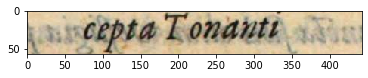

cepta Tonanti
cepta Tonanti
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0019.xml	0019.png
(557.0, 1463.0, 1250.0, 1533.0)


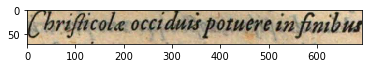

hriicolæ occiads potuere in ſinibu
Chriſticolæ occiduis potuere in finibus
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0019.xml	0019.png
(620.0, 1528.0, 707.0, 1581.0)


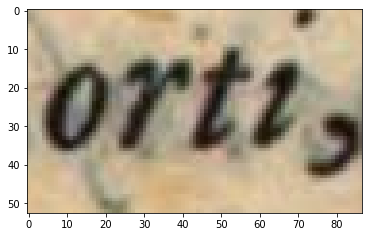

orti,
orti,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0019.xml	0019.png
(945.0, 1855.0, 1245.0, 1932.0)


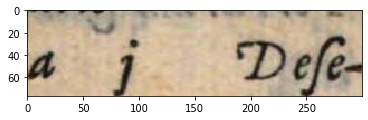

aj Dec-
a j Deſe-
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0020.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0020.xml	0020.png
(334.0, 255.0, 1176.0, 313.0)


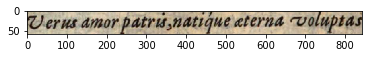

erus amor patris, natique æterna voluptas
Verus amor patris, natiq́ue æterna voluptas
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0020.xml	0020.png
(330.0, 1345.0, 1089.0, 1401.0)


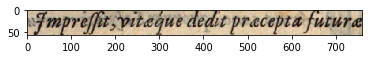

mpreſſit, vitæque dedit præceptæ futuræ
Jmpreſſit, vitæq́ue dedit præcepta futuræ
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0020.xml	0020.png
(344.0, 1401.0, 1061.0, 1459.0)


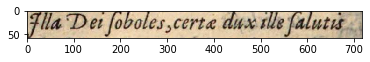

la Dei ſoboles, certæ dux ille ſalutis
Jlla Dei ſoboles, certæ dux ille ſalutis
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0021.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0021.xml	0021.png
(435.0, 150.0, 998.0, 181.0)


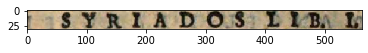

sYRIADOSLIB. I.
SYRIADOS LIB. I.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0021.xml	0021.png
(218.0, 261.0, 1050.0, 317.0)


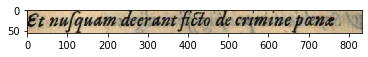

t nuſquam deerant ficto de crimine pœnæ
Et nuſquam deerant ficto de crimine pœnæ
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0021.xml	0021.png
(796.0, 1868.0, 914.0, 1918.0)


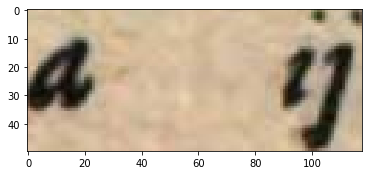

a ij
a ij
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0022.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0022.xml	0022.png
(330.0, 544.0, 1033.0, 599.0)


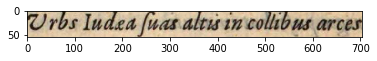

rbs Iudea ſuas altis in collibus arces
Vrbs Iudæa ſuas altis in collibus arces
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0023.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0023.xml	0023.png
(177.0, 204.0, 989.0, 269.0)


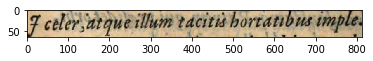

celer, atque illum tacitis hortatibus imple.
J celer, atque illum tacitis hortatibus imple.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0023.xml	0023.png
(173.0, 673.0, 1093.0, 733.0)


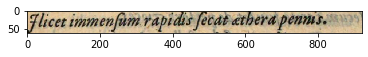

licet immenſum rapidis ſecat æthera pennis.
Jlicet immenſum rapidis ſecat æthera pennis.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0024.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0024.xml	0024.png
(378.0, 747.0, 1366.0, 811.0)


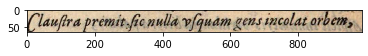

lauſtra premit ſic nulla vſquam gens incolat orbem,
Clauſtra premit ſic nulla vſquam gens incolat orbem,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0025.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0025.xml	0025.png
(434.0, 144.0, 1008.0, 206.0)


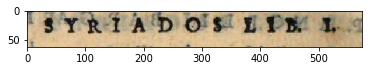

sTRIAD O LI I.
SYRIADOS LIB I.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0025.xml	0025.png
(1147.0, 1879.0, 1201.0, 1935.0)


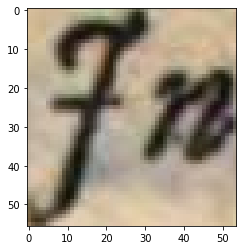

n
Jn
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0026.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0027.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0028.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0029.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0029.xml	0029.png
(203.0, 1327.0, 1045.0, 1383.0)


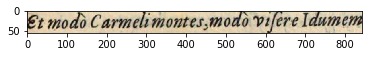

t modò Carmelimontes, modò viſere Idumem
Et modò Carmeli montes, modò viſere Idumem
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0029.xml	0029.png
(868.0, 1913.0, 1301.0, 1967.0)


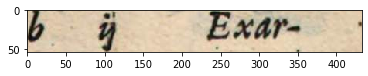

biExar-
b ij Exar-
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0030.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0030.xml	0030.png
(348.0, 1356.0, 1169.0, 1416.0)


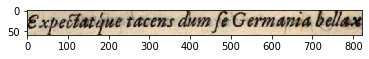

xpectatque tacens dum ſe Germania bella
Expectatq́ue tacens dum ſe Germania bellax
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0031.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0031.xml	0031.png
(220.0, 1856.0, 1142.0, 1924.0)


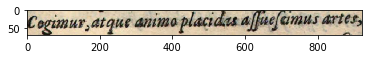

ogimur, atque animo placidas aſſueſcimus artes,
Cogimur, atque animo placidas aſſueſcimus artes,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0031.xml	0031.png
(1082.0, 1912.0, 1257.0, 1953.0)


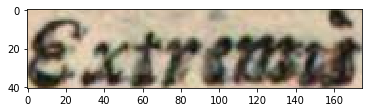

xtrem
Extremis
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0032.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0032.xml	0032.png
(344.0, 316.0, 1116.0, 377.0)


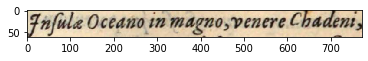

nſulæ Oceano in magno, venere Chadeni,
Jnſulæ Oceano in magno, venere Chadeni,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0033.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0033.xml	0033.png
(195.0, 249.0, 1130.0, 308.0)


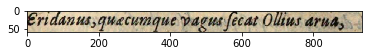

ridanus, quæcumque vagus ſecat Ollius arua,
Eridanus, quæcumque vagus ſecat Ollius arua,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0033.xml	0033.png
(196.0, 1552.0, 1197.0, 1609.0)


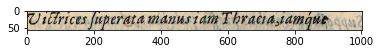

ictrices ſuperata manus iam Thracia, iamq́us
Victrices ſuperata manus iam Thracia, iamq́ue
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0033.xml	0033.png
(195.0, 1729.0, 1150.0, 1789.0)


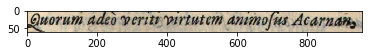

uorum adeò veriti virtutem animoſus Acarnan,
Quorum adeò veriti virtutem animoſus Acarnan,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0034.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0035.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0035.xml	0035.png
(411.0, 159.0, 1049.0, 212.0)


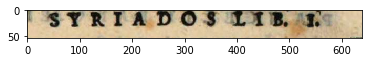

sYRIADOLII. I
SYRIADOS LIB. I.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0035.xml	0035.png
(194.0, 393.0, 1120.0, 453.0)


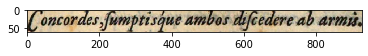

oncordes, ſumptisque ambos diſcedere ab arms.
Concordes, ſumptisq́ue ambos diſcedere ab armis.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0035.xml	0035.png
(194.0, 1404.0, 1141.0, 1461.0)


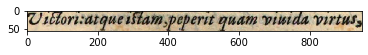

ictori:atque iftam, peperit quam viuida virtus,
Victori: atque istam, peperit quam viuida virtus,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0035.xml	0035.png
(200.0, 1879.0, 1034.0, 1937.0)


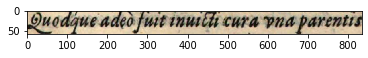

uodque adeò fuit inuicti xura vna parentis
Quodque adeò fuit inuicti cura vna parentis
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0035.xml	0035.png
(859.0, 1934.0, 1234.0, 1997.0)


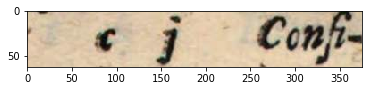

cj Cnſi-
c j Confi-
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0036.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0036.xml	0036.png
(331.0, 154.0, 384.0, 201.0)


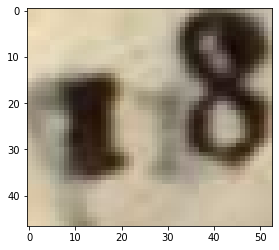

aS
18
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0036.xml	0036.png
(340.0, 312.0, 1189.0, 379.0)


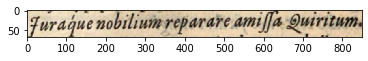

uraq́ue nobilium reparare amiſſa Quiritum.
Juraq́ue nobilium reparare amiſſa Quiritum.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0036.xml	0036.png
(350.0, 1127.0, 1152.0, 1190.0)


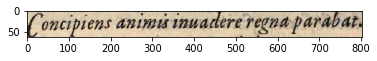

oncipiens animis inuadere regna parabat.
Concipiens animis inuadere regna parabat.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0036.xml	0036.png
(1182.0, 1883.0, 1365.0, 1942.0)


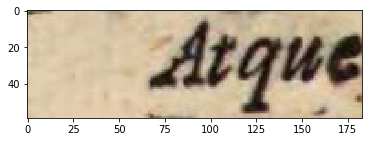

tque
Atque
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0037.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0037.xml	0037.png
(199.0, 263.0, 1094.0, 336.0)


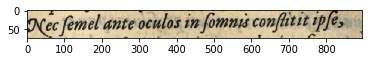

ec ſemel ante oculos in ſomns conſtitit ipſe,
Nec ſemel ante oculos in ſomnis conſtitit ipſe,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0037.xml	0037.png
(202.0, 630.0, 1151.0, 692.0)


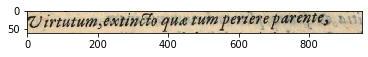

irtutum, extincto quæ tum periere parente,
Virtutum, extincto quæ tum periere parente,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0037.xml	0037.png
(201.0, 749.0, 1057.0, 810.0)


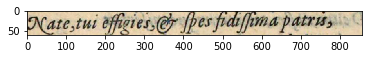

ate, tui eſſigies, e ſpes fidſſima patris,
Nate, tui effigies, & ſpes fidiſſima patris,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0037.xml	0037.png
(877.0, 1933.0, 1251.0, 1996.0)


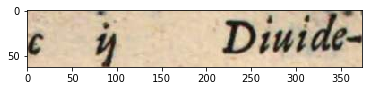

c i Diuidi-
c ij Diuide-
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0038.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0038.xml	0038.png
(332.0, 143.0, 1144.0, 183.0)


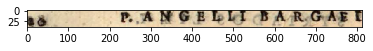

n AGEILI BAR GAEI

/home/alex/ocr4all/data/Barg_Syr_1585/processing/0038.xml	0038.png
(334.0, 314.0, 1359.0, 371.0)


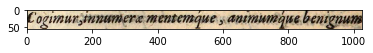

ogimur, innumeræ mentemque, animumque benignum
Cogimur, innumeræ mentemq́ue, animumq́ue benignum
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0038.xml	0038.png
(334.0, 487.0, 1114.0, 546.0)


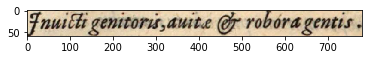

nuicti genitoris, auitæe & roboragentis.
Jnuicti genitoris, auitæ & robora gentis.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0039.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0039.xml	0039.png
(186.0, 395.0, 1084.0, 452.0)


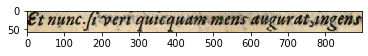

t nunc. ſi veri quicquam mens æugurat, ingens
Et nunc. ſi veri quicquam mens augurat, ingens
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0039.xml	0039.png
(189.0, 866.0, 1163.0, 929.0)


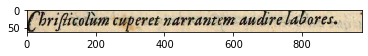

hriſticolùm cuperet narrantem audire labores.
Chriſticolùm cuperet narrantem audire labores.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0039.xml	0039.png
(181.0, 1762.0, 1054.0, 1819.0)


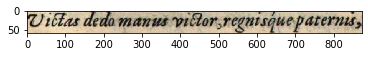

ictas dedo manus victor, regnisque paternis,
Victas dedo manus victor, regnisq́ue paternis,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0040.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0040.xml	0040.png
(360.0, 600.0, 1235.0, 662.0)


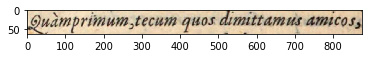

uàmprimum, tecum quos dimittamus amicos,
Quàmprimum, tecum quos dimittamus amicos,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0040.xml	0040.png
(358.0, 1013.0, 1266.0, 1074.0)


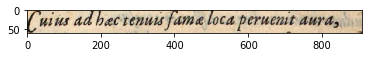

uius ad hæc tenuis famæ loca peruenit aura,
Cuius ad hæc tenuis famæ loca peruenit aura,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0040.xml	0040.png
(364.0, 1543.0, 1172.0, 1599.0)


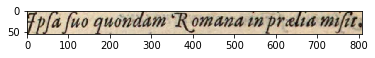

pſa ſuo quondam Romana in prælia miſit.
Jpſa ſuo quondam Romana in prælia miſit.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0041.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0041.xml	0041.png
(193.0, 443.0, 1036.0, 500.0)


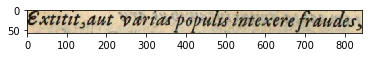

xtitit, aut varias populis intexere fraudes,
Extitit, aut varias populis intexere fraudes,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0041.xml	0041.png
(193.0, 562.0, 1036.0, 621.0)


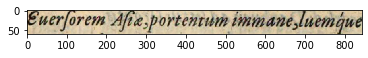

uerſorem Aſiæ, portentum immane, luemque
Euerſorem Aſiæ, portentum immane, luemq́ue
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0041.xml	0041.png
(181.0, 619.0, 1095.0, 678.0)


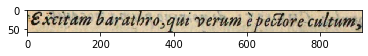

xcitam barathro, qui verum è pectore cultum,
Excitam barathro, qui verum è pectore cultum,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0041.xml	0041.png
(178.0, 919.0, 989.0, 980.0)


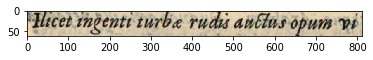

licet ingenti turbæ rudis auctus opum vi
Ilicet ingenti turbæ rudis auctus opum vi
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0041.xml	0041.png
(182.0, 1876.0, 963.0, 1943.0)


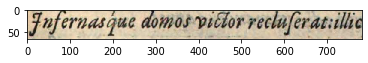

nfernasque domos victor recluſerat:illic
Jnfernasq́ue domos victor recluſerat: illic
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0042.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0043.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0043.xml	0043.png
(191.0, 797.0, 1008.0, 856.0)


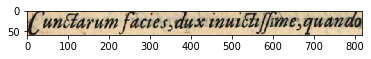

unctarum facies, du inuictiſſime, quando
Cunctarum facies, dux inuictiſſime, quando
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0043.xml	0043.png
(185.0, 1626.0, 979.0, 1690.0)


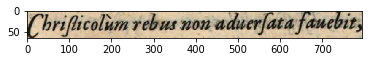

hriſticolùm rebus non aduerſata fauebit,
Chriſticolùm rebus non aduerſata fauebit,
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0043.xml	0043.png
(189.0, 1687.0, 1058.0, 1748.0)


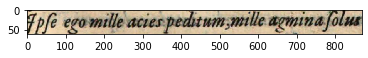

pſe ego mille acies peditum, mille agmina ſolus
Jpſe ego mille acies peditum, mille agmina ſolus
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0043.xml	0043.png
(162.0, 1746.0, 1060.0, 1809.0)


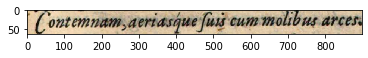

ontemnam, aeriasque ſuis cum molibus arces.
Contemnam, aeriasq́ue ſuis cum molibus arces.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0043.xml	0043.png
(899.0, 1923.0, 1218.0, 1986.0)


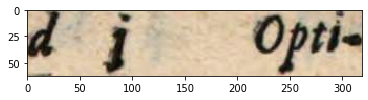

ad j pti-
d j Opti-
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0044.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0044.xml	0044.png
(578.0, 138.0, 1144.0, 181.0)


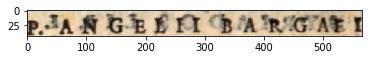

i IREAI

/home/alex/ocr4all/data/Barg_Syr_1585/processing/0044.xml	0044.png
(355.0, 429.0, 1207.0, 492.0)


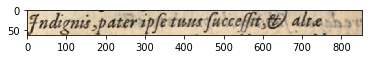

ndignis, pater ipſe tuus ſucceſſit, & altæ
Jndignis, pater ipſe tuus ſucceſſit, & altæ
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0044.xml	0044.png
(354.0, 1588.0, 1197.0, 1646.0)


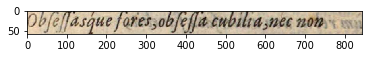

leſſasque ſores, obſeſſa cubilia, nec non
Obſeſſasq́ue ſores, obſeſſa cubilia, nec non
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0044.xml	0044.png
(353.0, 1647.0, 1332.0, 1706.0)


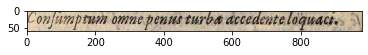

onſumptum omne penus turbæ accedente loquaci.
Conſumptum omne penus turbæ accedente loquaci.
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0045.xml
/home/alex/ocr4all/data/Barg_Syr_1585/processing/0045.xml	0045.png
(428.0, 144.0, 993.0, 195.0)


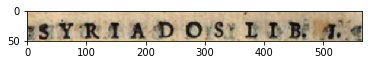

sYRIADOS LIB. .


In [ ]:
for page in pagexml[12:]:
    print(page)
    img_basename = page.split('/')
    tree = etree.parse(page)
    NSMAP = {'xmlns' : tree.xpath('namespace-uri(.)')}
    imageFilename, imageHeight, imageWidth = tree.find('xmlns:Page', NSMAP).attrib.values()
    img = mpimg.imread(project_directory+"/input/"+imageFilename)
    lines = tree.findall('//xmlns:TextLine', NSMAP)
    changed = False # Switch
    for l in lines:
        namespace = l.xpath('namespace-uri(.)')
        try:
            gt = l.find('xmlns:TextEquiv[@index="0"]/xmlns:Unicode', NSMAP).text
        except:
            gt = None
        try:
            ocr = l.find('xmlns:TextEquiv[@index="1"]/xmlns:Unicode', NSMAP).text
        except:
            ocr = ""
        line_coords = l.find('xmlns:Coords', NSMAP).attrib['points'].split(' ')
        vertices = [list(map(int,vertex.split(','))) for vertex in line_coords]
        vertices.append(vertices[0])
        xs,ys = zip(*vertices)
        polygon = Polygon(vertices)
        bbox = polygon.bounds
        try:
            match = re.search(regex,ocr)
        except:
            match = None
        if not gt and match:
            print(f"{page}\t{imageFilename}")
            print(bbox)
            try:
                line_snippet = img[int(bbox[1]):int(bbox[3]),int(bbox[0]):int(bbox[2])]
                plt.imshow(line_snippet)
                plt.show()
                pyperclip.copy(ocr)
                print(ocr)
                new_gt = input()
                if new_gt == " d":
                    l.getparent().remove(l)
                    changed = True
                elif len(new_gt) < 2:
                    pass
                else:
                    gt_elem = etree.SubElement(l,'{'+namespace+'}'+'TextEquiv', index="0")
                    gt_unicode = etree.SubElement(gt_elem,'{'+namespace+'}'+'Unicode')
                    gt_unicode.text = new_gt
                    changed = True
            except Exception as e:
                print(e)
            plt.clf()
    if changed:
        # make backup of original PageXML
        new_dir = project_directory+"/backup_processing/"
        try:
            shutil.copy(page,new_dir+img_basename[-1])
        except FileNotFoundError:
            
            os.mkdir(project_directory+"/backup_processing")
            shutil.copy(page,new_dir+img_basename[-1])
        # write new tree to  
        tree.write(open(page, 'wb'), pretty_print=False)